# GO-BGC Argopy Workshop

In [50]:
from argopy import DataFetcher  # This is the class to work with Argo data
from argopy import ArgoIndex  #  This is the class to work with Argo index
from argopy import ArgoNVSReferenceTables  # This is the class to retrieve data from Argo reference tables
from argopy import ArgoColors  # This is a class with usefull pre-defined colors
from argopy.plot import scatter_map, scatter_plot  # Functions to easily make maps and plots

# Make a fresh start
import argopy
argopy.set_options(cachedir='cache_bgc')
#argopy.reset_options()
argopy.clear_cache()

#
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import cmocean
import xarray as xr
import cartopy.crs as ccrs
import pandas as pd
xr.set_options(display_expand_attrs = False)

# Load Storm Track

In [70]:
traj = pd.read_csv('sam_2021_ibtracs_data.csv')
traj_rows = traj.set_index(["ISO_TIME"])  # since this is a gridded data, it is useful to transorm from a table into an array 
traj_ds = xr.Dataset.from_dataframe(traj_rows)
traj_ds

<xarray.Dataset>
Dimensions:           (ISO_TIME: 117)
Coordinates:
  * ISO_TIME          (ISO_TIME) object '2021-09-22 18:00:00' ... '2021-10-07...
Data variables: (12/163)
    Unnamed: 0        (ISO_TIME) int64 0 1 2 3 4 5 6 ... 111 112 113 114 115 116
    SID               (ISO_TIME) object '2021266N10327' ... '2021266N10327'
    SEASON            (ISO_TIME) int64 2021 2021 2021 2021 ... 2021 2021 2021
    NUMBER            (ISO_TIME) int64 85 85 85 85 85 85 ... 85 85 85 85 85 85
    BASIN             (ISO_TIME) float64 nan nan nan nan nan ... nan nan nan nan
    SUBBASIN          (ISO_TIME) float64 nan nan nan nan nan ... nan nan nan nan
    ...                ...
    USA_SEARAD_NE     (ISO_TIME) object ' ' ' ' ' ' ' ' ' ' ... ' ' ' ' ' ' ' '
    USA_SEARAD_SE     (ISO_TIME) object ' ' ' ' ' ' ' ' ' ' ... ' ' ' ' ' ' ' '
    USA_SEARAD_SW     (ISO_TIME) object ' ' ' ' ' ' ' ' ' ' ... ' ' ' ' ' ' ' '
    USA_SEARAD_NW     (ISO_TIME) object ' ' ' ' ' ' ' ' ' ' ... ' ' ' ' ' ' ' '
    STORM_SPEED       (ISO_TIME) int64 12 13 14 16 16 16 ... 26 28 30 32 34 34
    STORM_DIR         (ISO_TIME) int64 280 279 278 277 279 ... 49 45 37 30 28

# Load Float Data

In [5]:
my_WMO = 5906436 #my hurricane ID
my_float= DataFetcher(ds='bgc', src='erddap',mode='expert', params='all').float(my_WMO).load()

In [12]:
float_ds = my_float.data
float_ds

<xarray.Dataset>
Dimensions:                          (N_POINTS: 34474)
Coordinates:
    LATITUDE                         (N_POINTS) float64 ...
    LONGITUDE                        (N_POINTS) float64 ...
    TIME                             (N_POINTS) datetime64[ns] ...
  * N_POINTS                         (N_POINTS) int64 0 1 2 ... 34472 34473
Data variables: (12/54)
    BBP700                           (N_POINTS) float32 ...
    BBP700_ADJUSTED                  (N_POINTS) float32 ...
    BBP700_ADJUSTED_ERROR            (N_POINTS) float32 ...
    BBP700_ADJUSTED_QC               (N_POINTS) int64 0 0 0 1 0 0 ... 1 1 1 1 1
    BBP700_DATA_MODE                 (N_POINTS) <U1 'A' 'A' 'A' ... 'A' 'A' 'A'
    BBP700_QC                        (N_POINTS) int64 0 0 0 2 0 0 ... 2 2 2 2 2
    ...                               ...
    TEMP_ADJUSTED                    (N_POINTS) float32 ...
    TEMP_ADJUSTED_ERROR              (N_POINTS) float32 ...
    TEMP_ADJUSTED_QC                 (N_POINTS) int64 1 1 1 8 1 1 ... 1 1 1 1 1
    TEMP_DATA_MODE                   (N_POINTS) <U1 'D' 'D' 'D' ... 'D' 'D' 'D'
    TEMP_QC                          (N_POINTS) int64 1 1 1 8 1 1 ... 1 1 1 1 1
    TIME_QC                          (N_POINTS) int64 1 1 1 1 1 1 ... 1 1 1 1 1
Attributes: (7)

In [13]:
float_ds = float_ds.argo.point2profile()
float_ds

<xarray.Dataset>
Dimensions:                          (N_PROF: 62, N_LEVELS: 557)
Coordinates:
  * N_PROF                           (N_PROF) int64 0 1 2 3 4 ... 57 58 59 60 61
  * N_LEVELS                         (N_LEVELS) int64 0 1 2 3 ... 554 555 556
    LATITUDE                         (N_PROF) float64 23.87 24.05 ... 24.29 25.1
    LONGITUDE                        (N_PROF) float64 -65.73 -65.01 ... -51.47
    TIME                             (N_PROF) datetime64[ns] 2021-05-04T10:58...
Data variables: (12/54)
    BBP700                           (N_PROF, N_LEVELS) float32 nan nan ... nan
    BBP700_ADJUSTED                  (N_PROF, N_LEVELS) float32 1e+05 ... nan
    BBP700_ADJUSTED_ERROR            (N_PROF) float32 1e+05 1e+05 ... 1e+05
    BBP700_ADJUSTED_QC               (N_PROF, N_LEVELS) int64 0 0 0 ... 1 99999
    BBP700_DATA_MODE                 (N_PROF) <U1 'A' 'A' 'A' ... 'A' 'A' 'A'
    BBP700_QC                        (N_PROF, N_LEVELS) int64 0 0 0 ... 2 99999
    ...                               ...
    TEMP_ADJUSTED                    (N_PROF, N_LEVELS) float32 26.36 ... nan
    TEMP_ADJUSTED_ERROR              (N_PROF, N_LEVELS) float32 0.002 ... nan
    TEMP_ADJUSTED_QC                 (N_PROF, N_LEVELS) int64 1 1 1 ... 1 99999
    TEMP_DATA_MODE                   (N_PROF) <U1 'D' 'D' 'D' ... 'D' 'D' 'D'
    TEMP_QC                          (N_PROF, N_LEVELS) int64 1 1 1 ... 1 99999
    TIME_QC                          (N_PROF) int64 1 1 1 1 1 1 ... 1 1 1 1 1 1
Attributes: (8)

In [24]:
depth_min = 0
depth_max = 1000
step = 2
grid = np.arange(depth_min,depth_max,step)

In [25]:
float_interp = float_ds.argo.interp_std_levels(grid)
float_interp

<xarray.Dataset>
Dimensions:                     (N_PROF: 62, PRES_INTERPOLATED: 500)
Coordinates:
  * N_PROF                      (N_PROF) int64 0 1 2 3 4 5 ... 56 57 58 59 60 61
    LATITUDE                    (N_PROF) float64 23.87 24.05 ... 24.29 25.1
    LONGITUDE                   (N_PROF) float64 -65.73 -65.01 ... -52.67 -51.47
    TIME                        (N_PROF) datetime64[ns] 2021-05-04T10:58:27.0...
  * PRES_INTERPOLATED           (PRES_INTERPOLATED) int64 0 2 4 ... 994 996 998
Data variables: (12/28)
    BBP700                      (N_PROF, PRES_INTERPOLATED) float32 0.0004087...
    BBP700_ADJUSTED             (N_PROF, PRES_INTERPOLATED) float32 1e+05 ......
    BBP700_DATA_MODE            (N_PROF) <U1 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    CHLA                        (N_PROF, PRES_INTERPOLATED) float32 0.0365 .....
    CHLA_ADJUSTED               (N_PROF, PRES_INTERPOLATED) float32 1e+05 ......
    CHLA_DATA_MODE              (N_PROF) <U1 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    ...                          ...
    PSAL                        (N_PROF, PRES_INTERPOLATED) float32 36.75 ......
    PSAL_ADJUSTED               (N_PROF, PRES_INTERPOLATED) float32 36.75 ......
    PSAL_DATA_MODE              (N_PROF) <U1 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D'
    TEMP                        (N_PROF, PRES_INTERPOLATED) float32 26.36 ......
    TEMP_ADJUSTED               (N_PROF, PRES_INTERPOLATED) float32 26.36 ......
    TEMP_DATA_MODE              (N_PROF) <U1 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D'
Attributes: (8)

# Plot Trajectories

In [61]:
traj_ds

<xarray.Dataset>
Dimensions:           (ISO_TIME: 117, LAT: 117, LON: 114)
Coordinates:
  * ISO_TIME          (ISO_TIME) object '2021-09-22 18:00:00' ... '2021-10-07...
  * LAT               (LAT) float64 10.0 10.1 10.2 10.29 ... 55.2 56.58 58.1
  * LON               (LON) float64 -61.95 -61.9 -61.8 ... -25.4 -23.82 -22.3
Data variables: (12/161)
    Unnamed: 0        (ISO_TIME, LAT, LON) float64 nan nan nan ... nan nan 116.0
    SID               (ISO_TIME, LAT, LON) object nan nan ... '2021266N10327'
    SEASON            (ISO_TIME, LAT, LON) float64 nan nan nan ... nan 2.021e+03
    NUMBER            (ISO_TIME, LAT, LON) float64 nan nan nan ... nan nan 85.0
    BASIN             (ISO_TIME, LAT, LON) float64 nan nan nan ... nan nan nan
    SUBBASIN          (ISO_TIME, LAT, LON) float64 nan nan nan ... nan nan nan
    ...                ...
    USA_SEARAD_NE     (ISO_TIME, LAT, LON) object nan nan nan ... nan nan ' '
    USA_SEARAD_SE     (ISO_TIME, LAT, LON) object nan nan nan ... nan nan ' '
    USA_SEARAD_SW     (ISO_TIME, LAT, LON) object nan nan nan ... nan nan ' '
    USA_SEARAD_NW     (ISO_TIME, LAT, LON) object nan nan nan ... nan nan ' '
    STORM_SPEED       (ISO_TIME, LAT, LON) float64 nan nan nan ... nan nan 34.0
    STORM_DIR         (ISO_TIME, LAT, LON) float64 nan nan nan ... nan nan 28.0

In [73]:
float_interp

<xarray.Dataset>
Dimensions:                     (N_PROF: 62, PRES_INTERPOLATED: 500)
Coordinates:
  * N_PROF                      (N_PROF) int64 0 1 2 3 4 5 ... 56 57 58 59 60 61
    LATITUDE                    (N_PROF) float64 23.87 24.05 ... 24.29 25.1
    LONGITUDE                   (N_PROF) float64 -65.73 -65.01 ... -52.67 -51.47
    TIME                        (N_PROF) datetime64[ns] 2021-05-04T10:58:27.0...
  * PRES_INTERPOLATED           (PRES_INTERPOLATED) int64 0 2 4 ... 994 996 998
Data variables: (12/28)
    BBP700                      (N_PROF, PRES_INTERPOLATED) float32 0.0004087...
    BBP700_ADJUSTED             (N_PROF, PRES_INTERPOLATED) float32 1e+05 ......
    BBP700_DATA_MODE            (N_PROF) <U1 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    CHLA                        (N_PROF, PRES_INTERPOLATED) float32 0.0365 .....
    CHLA_ADJUSTED               (N_PROF, PRES_INTERPOLATED) float32 1e+05 ......
    CHLA_DATA_MODE              (N_PROF) <U1 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    ...                          ...
    PSAL                        (N_PROF, PRES_INTERPOLATED) float32 36.75 ......
    PSAL_ADJUSTED               (N_PROF, PRES_INTERPOLATED) float32 36.75 ......
    PSAL_DATA_MODE              (N_PROF) <U1 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D'
    TEMP                        (N_PROF, PRES_INTERPOLATED) float32 26.36 ......
    TEMP_ADJUSTED               (N_PROF, PRES_INTERPOLATED) float32 26.36 ......
    TEMP_DATA_MODE              (N_PROF) <U1 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D'
Attributes: (8)

Text(0.5, 1.0, 'Float & Sam Trajectories')

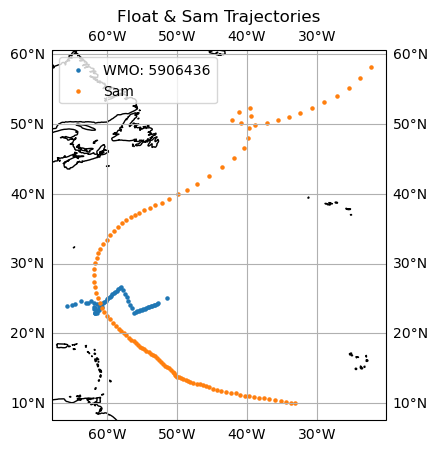

In [79]:
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(float_interp.LONGITUDE,float_interp.LATITUDE,transform=ccrs.PlateCarree(),s=5,label='WMO: {}'.format(float_interp.PLATFORM_NUMBER[0].data))
plt.scatter(traj_ds.LON,traj_ds.LAT,transform=ccrs.PlateCarree(),s=5,label='Sam')
#ax.set_extent([-70,-50,20,30])
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.legend()
plt.title('Float & Sam Trajectories')

In [ ]:
plt.figure(figsize=20,20)
float_interp.TEMP